# Waste Clssifier Image Classification Model


## 1. Loading Data

In [16]:
!pip install torch torchvision kagglehub


In [17]:
import os
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [18]:
class GarbageDataset(Dataset):
    def __init__(self, root, transform=None):

        self.root = root
        self.transform = transform

        # Get all class folders
        self.classes = sorted([d for d in os.listdir(root)
                              if os.path.isdir(os.path.join(root, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # Build list of (image_path, label) tuples
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root, class_name)
            class_idx = self.class_to_idx[class_name]

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [19]:
import kagglehub
path = kagglehub.dataset_download("zlatan599/garbage-dataset-classification")

print("Path to dataset files:", path)

print("\nContents of dataset directory:")
for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        print(f"📁 {item}/ - {len(os.listdir(item_path))} items")
    else:
        print(f"📄 {item}")

# Check one level deeper
print("\nLooking deeper:")
for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        for subitem in os.listdir(item_path)[:5]:  # Show first 5 items
            print(f"  {item}/{subitem}")

Path to dataset files: C:\Users\sunny\.cache\kagglehub\datasets\zlatan599\garbage-dataset-classification\versions\5

Contents of dataset directory:
📁 Garbage_Dataset_Classification/ - 2 items

Looking deeper:
  Garbage_Dataset_Classification/images
  Garbage_Dataset_Classification/metadata.csv


In [20]:
dataset_path = os.path.join(path, "Garbage_Dataset_Classification", "images")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load full dataset
full_dataset = GarbageDataset(
    root=dataset_path,
    transform=transform
)
# Get indices and labels for stratified split
indices = list(range(len(full_dataset)))
labels = [full_dataset.samples[i][1] for i in indices]

# Split 80/20 train/test with stratification
train_indices, test_indices = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

train_data = Subset(full_dataset, train_indices)
test_data = Subset(full_dataset, test_indices)

print(f"Total samples: {len(full_dataset)}")
print(f"Train samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Classes: {full_dataset.classes}")

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# get the length of the output:
print(f"Output length: {len(full_dataset.classes)}")

Total samples: 13901
Train samples: 11120
Test samples: 2781
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Output length: 6


## 2. Visualizing the data

Image shape: torch.Size([3, 224, 224])


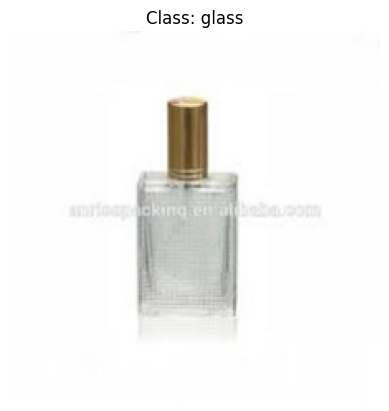

In [21]:
image,label = train_data[8]
print(f"Image shape: {image.shape}")
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Class: {full_dataset.classes[label]}")
plt.axis('off')
plt.show()

## 3. Creating the Model

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

This model uses Convolutional Nerual Networks to classify images

In [23]:
class WasteClassifierModelV1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.block1 = nn.Sequential(
      #create a conv layer
      nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.block2 = nn.Sequential(
      #create a conv layer
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.block3 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*4, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)  # 56 -> 28
    )

    self.block4 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*8, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)  # 28 -> 14
    )

    self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*8, out_features=256), # Assuming output size after conv/pool is 56*56
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(in_features=256, out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.global_avg_pool(x)
    return self.classifier(x)

In [24]:
torch.manual_seed(42)
model_1 = WasteClassifierModelV1(input_shape=3, hidden_units=64, output_shape=len(full_dataset.classes)).to(device)
model_1

WasteClassifierModelV1(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

### setting up loss function and optimizer

In [25]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_1.parameters(),
    lr=0.001
)

In [26]:
def accuracy_fn(y_true, y_pred):

    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [27]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):

    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### Training model

In [28]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [29]:
from tqdm.auto import tqdm
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_1 = timer()

# Train and test model
epochs = 15
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader ,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_loader ,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_1 = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_model_1,
                                           end=train_time_end_model_1,
                                           device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0
---------


  0%|          | 0/15 [00:02<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x256 and 512x256)

In [30]:
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("No GPU available - using CPU (will be slow!)")

No GPU available - using CPU (will be slow!)


In [31]:
!nvidia-smi

Sun Nov  9 19:48:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   55C    P8              5W /   20W |     152MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [26]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


^C
